#Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Load Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Gold_Historical_Data_01-01-2021_07-04-2021 .csv to Gold_Historical_Data_01-01-2021_07-04-2021 .csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Gold_Historical_Data_01-01-2021_07-04-2021 .csv']))

In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jul 04, 2021","1,786.40","1,788.00","1,788.00","1,785.80",-,0.17%
1,"Jul 02, 2021","1,783.30","1,777.50","1,795.90","1,774.40",205.86K,0.37%
2,"Jul 01, 2021","1,776.80","1,770.80","1,783.40","1,765.90",171.44K,0.29%
3,"Jun 30, 2021","1,771.60","1,761.90","1,774.70","1,753.20",177.89K,0.45%
4,"Jun 29, 2021","1,763.60","1,778.80","1,779.20","1,750.10",239.91K,-0.96%


Data Exploration

In [ ]:
df.describe()

,Date,Price,Open,High,Low,Vol.,Change %
count,134,134,134,134,134,134,134
unique,134,131,127,132,132,122,108
top,"Jun 11, 2021","1,782.20","1,773.90","1,846.50","1,730.70",-,-0.32%
freq,1,2,2,2,2,8,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      134 non-null    object
 1   Price     134 non-null    object
 2   Open      134 non-null    object
 3   High      134 non-null    object
 4   Low       134 non-null    object
 5   Vol.      134 non-null    object
 6   Change %  134 non-null    object
dtypes: object(7)
memory usage: 7.5+ KB


Price Data

In [ ]:
price_df = df[['Date','Price']]
price_df.head()

,Date,Price
0,"Jul 04, 2021","1,786.40"
1,"Jul 02, 2021","1,783.30"
2,"Jul 01, 2021","1,776.80"
3,"Jun 30, 2021","1,771.60"
4,"Jun 29, 2021","1,763.60"


In [ ]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    134 non-null    object
 1   Price   134 non-null    object
dtypes: object(2)
memory usage: 2.2+ KB


In [ ]:
# convert price to float 
price_df['Price'] = price_df['Price'].str.replace(',', '').astype(float)
price_df.head()

,Date,Price
0,"Jul 04, 2021",1786.4
1,"Jul 02, 2021",1783.3
2,"Jul 01, 2021",1776.8
3,"Jun 30, 2021",1771.6
4,"Jun 29, 2021",1763.6


In [ ]:
# Cleaning up the data (actually the data is missing at weekend and holidays)
price_df.isnull().values.any()


False

In [ ]:
price_df.shape

(134, 2)

Set Date as index

In [ ]:
price_df.index = pd.to_datetime(price_df['Date'])
price_df.head()

,Date,Price
Date,,
2021-07-04,"Jul 04, 2021",1786.4
2021-07-02,"Jul 02, 2021",1783.3
2021-07-01,"Jul 01, 2021",1776.8
2021-06-30,"Jun 30, 2021",1771.6
2021-06-29,"Jun 29, 2021",1763.6


Visualization

Text(0.5, 1.0, 'Gold Price in 2021')

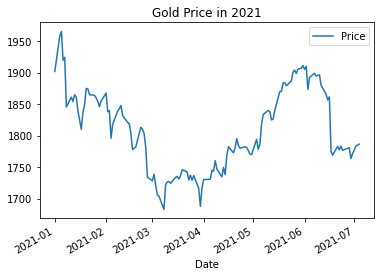

In [ ]:
price_df.plot()
plt.title('Gold Price in 2021')

Autocorrelation plot with Lag 1

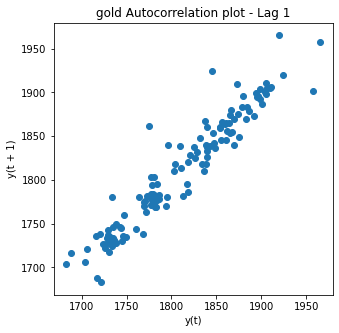

In [ ]:
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(price_df['Price'], lag=1)
plt.title('gold Autocorrelation plot - Lag 1');

The autocorrelation plot with lag 1 above telling us there is some correlation in prices with respect to prices from previous 1 day of lag which sets up the stage of forecasting future prices based on past price data

Autocorrelation plot with Lag 5

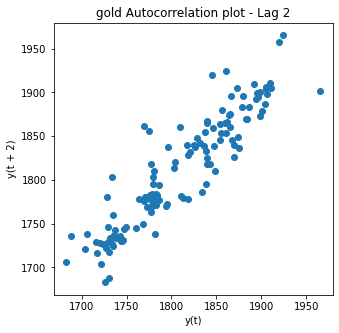

In [ ]:
plt.figure(figsize=(5,5))
lag_plot(price_df['Price'], lag=2)
plt.title('gold Autocorrelation plot - Lag 2');

Lag 1 autocorrelations show better correlation!

Build Train-Test Datasets

In [ ]:
price_df=price_df.reindex(index=price_df.index[::-1])

In [ ]:
train_data, test_data = price_df.iloc[0:int(len(df)*0.8), :], price_df.iloc[int(len(df)*0.8):, :]

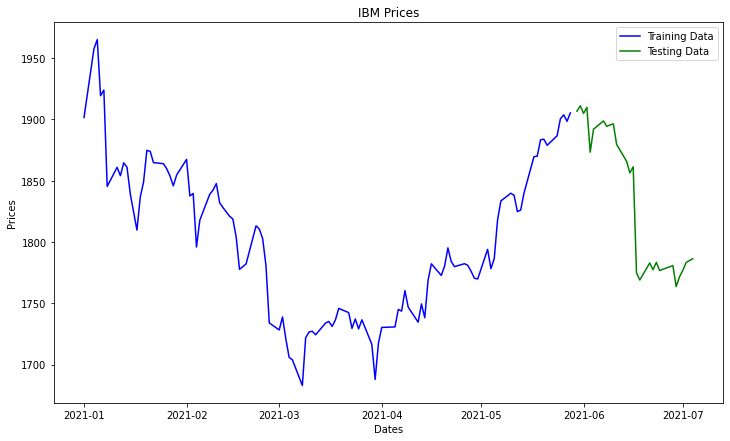

In [ ]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Price'], 'blue', label='Training Data')
plt.plot(test_data['Price'], 'green', label='Testing Data')
plt.legend();

ARIMA (AutoRegressive Integrated Moving Average)

Stationarity of the data - Determine the d value

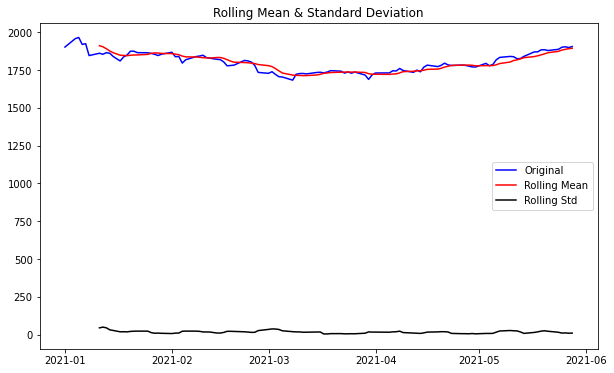

In [ ]:
window = 7
train_series = train_data['Price']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');
    

In [ ]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -1.488322
p-value                          0.539280
#Lags Used                       0.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64

we can observe that the p-value is 0.539 which proves that our series is not stationary.

Apply a first order differencing on the training data

In [ ]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)
train_diff

Date
2021-01-04    56.0
2021-01-05     7.6
2021-01-06   -45.8
2021-01-07     4.6
2021-01-08   -78.6
              ... 
2021-05-24     7.8
2021-05-25    13.8
2021-05-26     3.3
2021-05-27    -5.3
2021-05-28     6.8
Name: Price, Length: 106, dtype: float64

Visualize Rolling statistics for differenced train data

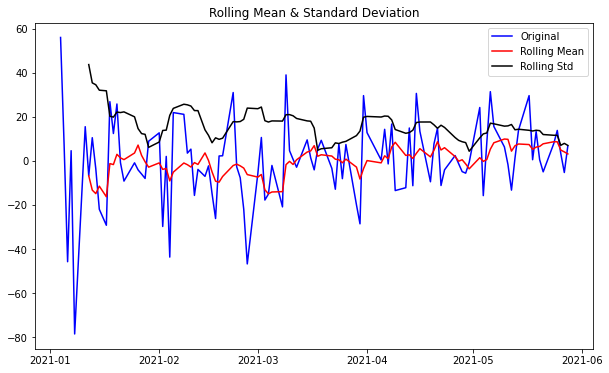

In [ ]:
#Determing rolling statistics
rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

Compute AD-Fuller Stats for differenced train data

In [ ]:
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.085308e+01
p-value                        1.511429e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.050000e+02
Critical Value (1%)           -3.494220e+00
Critical Value (5%)           -2.889485e+00
Critical Value (10%)          -2.581676e+00
dtype: float64

After differencing, the p-value is extremely small. Thus this series is very likely to be stationary

ACF Plots (Auto Correlation Function)

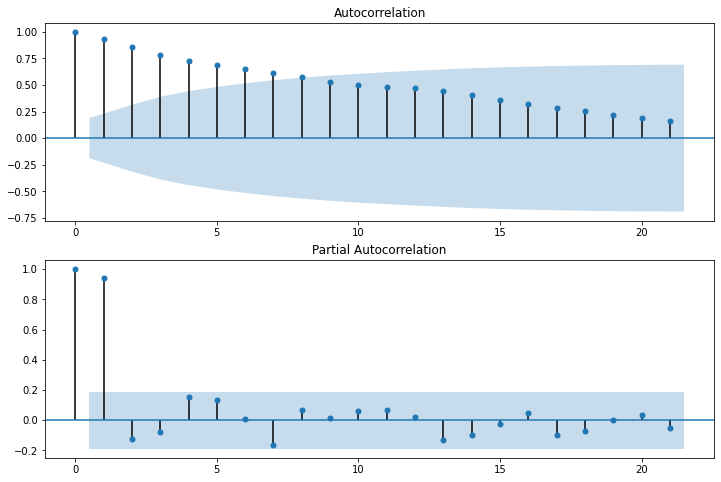

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

Plot ACF and PACF on the differenced train series

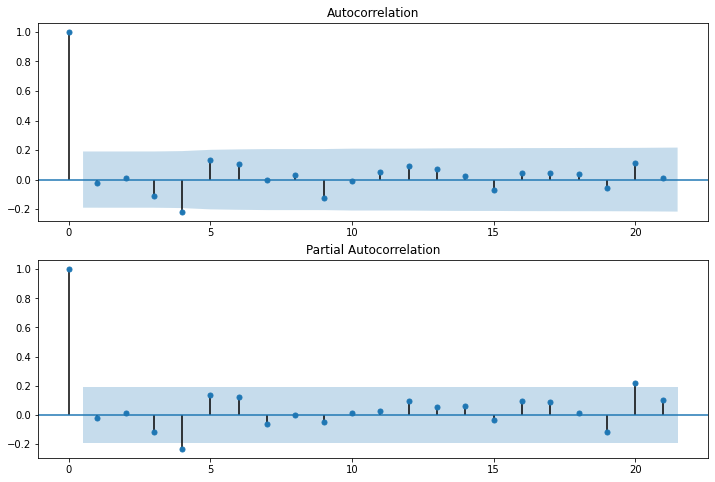

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

Arima with d=1, p=4 and q=0

Evaluation of ARIMA Model

In [ ]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
 

Difference the Test Series

In [ ]:
test_series = test_data['Price']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)

Train and Forecast using ARIMA Model 

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    # START_CODE_HERE - call the ARIMA Method with history and params
    model = ARIMA(history, order=(4,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit()  # fit the model
    # END_CODE_HERE

    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 5== 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=3.6622210372461566, Expected=4.400000000000091
Test Series Point: 5	Predicted=-4.01656894189917, Expected=6.7999999999999545
Test Series Point: 10	Predicted=-0.05031862600231207, Expected=-13.699999999999818
Test Series Point: 15	Predicted=-31.694004345542517, Expected=13.900000000000091
Test Series Point: 20	Predicted=4.885540699144749, Expected=2.900000000000091
Test Series Point: 25	Predicted=4.186113066620659, Expected=3.1000000000001364
CPU times: user 3.37 s, sys: 18.6 ms, total: 3.39 s
Wall time: 3.42 s


Reverse Transform the forecasted values

In [ ]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((27,), (27,))

Evaluate model performance

In [ ]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 1346.861
Symmetric Mean absolute percentage error: 1.330


Let's Visualize the forecast results

In [ ]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_predictions)
reverse_predictions_series.index = test_series.index

Visualizing train, test and forecast prices

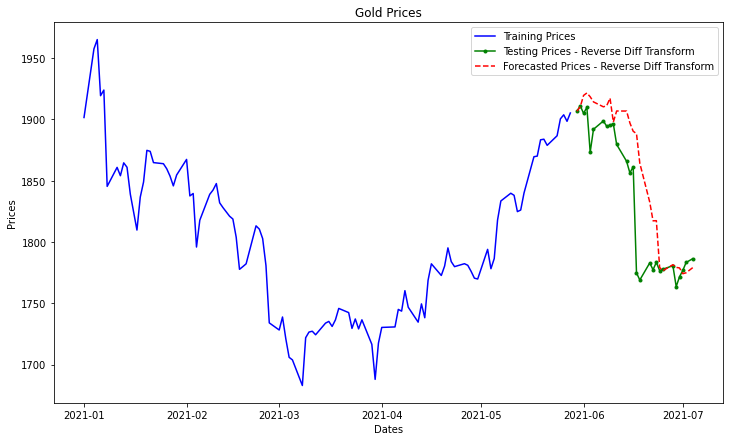

In [ ]:
plt.figure(figsize=(12,7))
plt.title('Gold Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

Visualize only test and forecast prices

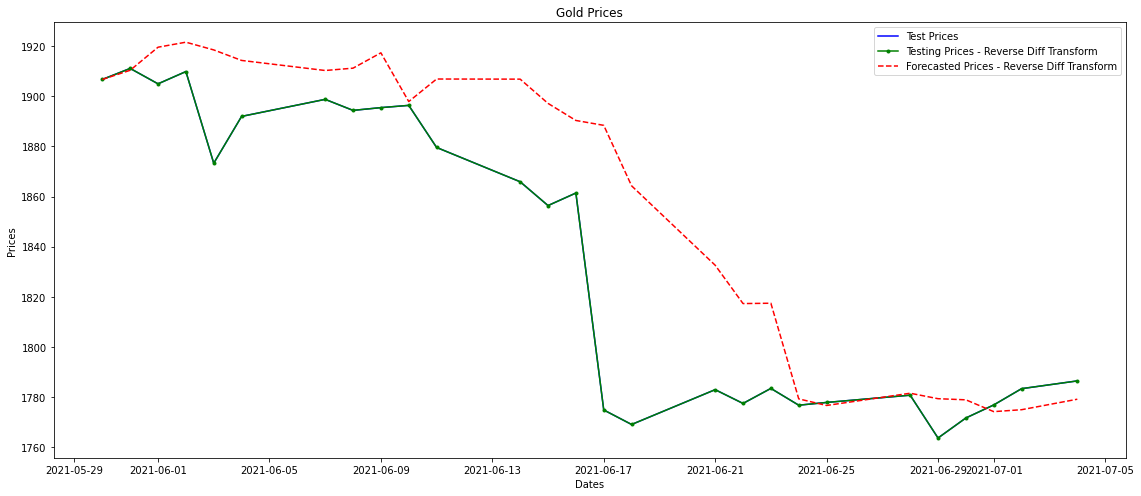

In [ ]:
plt.figure(figsize=(16,7))
plt.title('Gold Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(test_series, color='blue', label='Test Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.tight_layout()
plt.legend();

Time Series Forecasting with Deep Learning

In [ ]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

%tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

TensorFlow 1.x selected.


Build Train-Test Datasets

In [ ]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = price_df.iloc[0:int(len(df)*0.8), :], price_df.iloc[int(len(df)*0.8):, :]
train_series = train_data['Price']
test_series = test_data['Price']
train_series.shape, test_series.shape

((107,), (27,))

 Visualize train and test price data

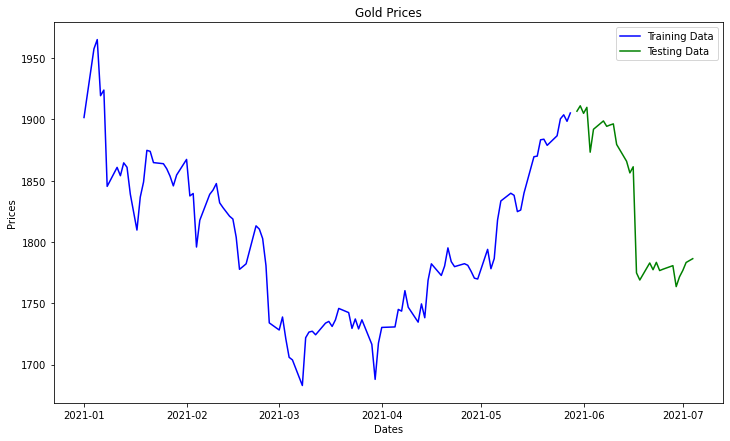

In [ ]:
plt.figure(figsize=(12,7))
plt.title('Gold Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, 'blue', label='Training Data')
plt.plot(test_series, 'green', label='Testing Data')
plt.legend();

Scaling

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
# START_CODE_HERE
# prepare data for normalization
values = train_series.values
values = values.reshape((len(values), 1))
scaler = sc.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
training_set_scaled = sc.transform(values)
# END_CODE_HERE

Min: 1682.900000, Max: 1965.200000


In [ ]:
training_set_scaled.shape

(107, 1)

Train Data Preparation

In [ ]:

X_train = []
y_train = []
for i in range(4, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-4:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((103, 4), (103,))

Reshape X_train

In [ ]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [ ]:
X_train.shape

(103, 4, 1)

LSTM Regression model

In [ ]:
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=200))

regressor.add(Dropout(0.3))


# The output layer
regressor.add(Dense(1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
regressor.compile(optimizer='rmsprop', loss='mse')

regressor.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 4, 200)            161600    
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 200)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________


Train the model

In [ ]:
regressor.fit(X_train,y_train, epochs=40, batch_size=64, validation_split=0.1, shuffle=False)

Train on 92 samples, validate on 11 samples
Epoch 1/40
92/92 [==============================] - 3s 37ms/sample - loss: 0.1516 - val_loss: 0.1110
Epoch 2/40
92/92 [==============================] - 0s 1ms/sample - loss: 0.0216 - val_loss: 0.0335
Epoch 3/40
92/92 [==============================] - 0s 1ms/sample - loss: 0.0099 - val_loss: 0.0111
Epoch 4/40
92/92 [==============================] - 0s 1ms/sample - loss: 0.0153 - val_loss: 0.0142
Epoch 5/40
92/92 [==============================] - 0s 1ms/sample - loss: 0.0135 - val_loss: 0.0103
Epoch 6/40
92/92 [==============================] - 0s 1ms/sample - loss: 0.0142 - val_loss: 0.0174
Epoch 7/40
92/92 [==============================] - 0s 2ms/sample - loss: 0.0115 - val_loss: 0.0114
Epoch 8/40
92/92 [==============================] - 0s 1ms/sample - loss: 0.0137 - val_loss: 0.0146
Epoch 9/40
92/92 [==============================] - 0s 1ms/sample - loss: 0.0132 - val_loss: 0.0156
Epoch 10/40
92/92 [==============================] - 0s

Test Data Forecasting

In [ ]:
train_series.tail(20)

Date
2021-05-03    1794.0
2021-05-04    1778.2
2021-05-05    1786.5
2021-05-06    1817.9
2021-05-07    1833.5
2021-05-10    1839.8
2021-05-11    1838.1
2021-05-12    1824.8
2021-05-13    1826.1
2021-05-14    1840.0
2021-05-17    1869.6
2021-05-18    1870.1
2021-05-19    1883.4
2021-05-20    1883.9
2021-05-21    1878.9
2021-05-24    1886.7
2021-05-25    1900.5
2021-05-26    1903.8
2021-05-27    1898.5
2021-05-28    1905.3
Name: Price, dtype: float64

In [ ]:
train_last60 = train_series.tail(4)
print(train_last60.shape)
assert train_last60.shape == (4,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

(4,)


In [ ]:
test_series.shape

(27,)

Combine both train_last60 and test_series together

In [ ]:
new_test_series =  pd.concat([train_last60, test_series])
print(new_test_series.shape)
assert new_test_series.shape == (31,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

(31,)


Scale the test dataset (new_test_series) using the trained MinMaxScaler transformer - sc

In [ ]:
new_test_series

Date
2021-05-25    1900.50
2021-05-26    1903.80
2021-05-27    1898.50
2021-05-28    1905.30
2021-05-30    1906.75
2021-05-31    1911.15
2021-06-01    1905.00
2021-06-02    1909.90
2021-06-03    1873.30
2021-06-04    1892.00
2021-06-07    1898.80
2021-06-08    1894.40
2021-06-09    1895.50
2021-06-10    1896.40
2021-06-11    1879.60
2021-06-14    1865.90
2021-06-15    1856.40
2021-06-16    1861.40
2021-06-17    1774.80
2021-06-18    1769.00
2021-06-21    1782.90
2021-06-22    1777.40
2021-06-23    1783.40
2021-06-24    1776.70
2021-06-25    1777.80
2021-06-28    1780.70
2021-06-29    1763.60
2021-06-30    1771.60
2021-07-01    1776.80
2021-07-02    1783.30
2021-07-04    1786.40
Name: Price, dtype: float64

In [ ]:
# prepare data for normalization
values = new_test_series.values
values = values.reshape((len(values), 1))
test_set_scaled  = sc.transform(values)

Prepare Test dataset Windows of 60 days each

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(4,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-4:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(27, 4, 1)

Model Prediction and Reverse Transform of Prices

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price_revtrans = sc.inverse_transform(predicted_stock_price).ravel()
predicted_stock_price_revtrans_series = pd.Series(predicted_stock_price_revtrans)
predicted_stock_price_revtrans_series.index = test_series.index
predicted_stock_price_revtrans_series.shape, test_series.shape

((27,), (27,))

Model Evaluation

In [ ]:
# Evaluating our model
error = mean_squared_error(test_series, predicted_stock_price_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, predicted_stock_price_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 760.665
Symmetric Mean absolute percentage error: 1.124


Visualizing the results from model predictions

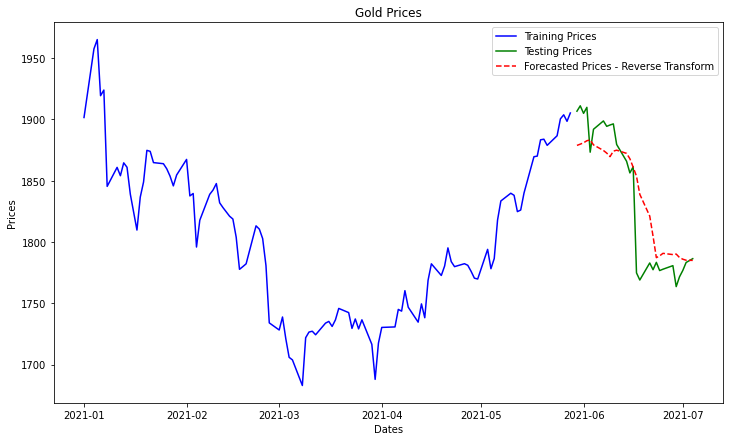

In [ ]:
plt.figure(figsize=(16,7))
plt.title('Gold Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

Visualize only test and forecast prices

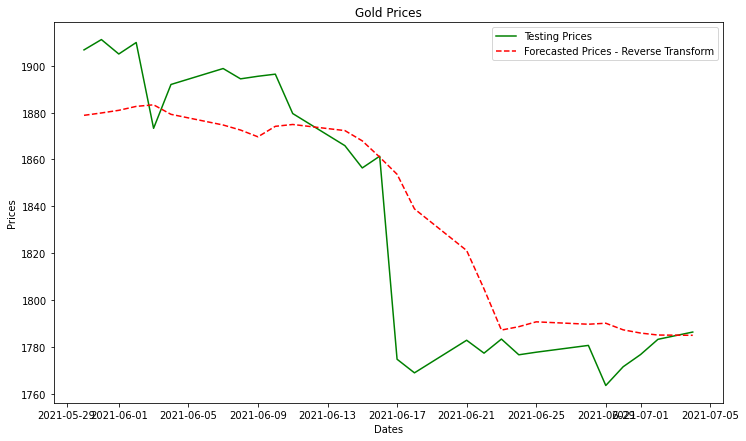

In [ ]:
plt.figure(figsize=(12,7))
plt.title('Gold Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();